In [3]:
import os
import numpy as np
#%matplotlib widget
import matplotlib.pyplot as plt
import os
import pandas as pd
from tqdm import tqdm

# Import necessary fitting modules
#from lmfit import minimize, Parameters, Parameter, printfuncs, fit_report
from scipy.optimize import fmin,leastsq,minimize

from shapely.geometry import Point,LineString
from shapely.geometry.polygon import Polygon

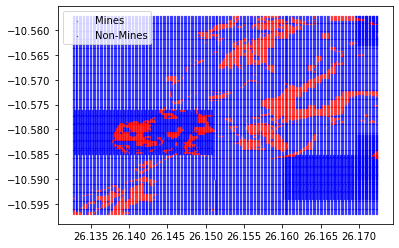

In [5]:
# Compiled csv status
# This file should not be huge (>few hundres MB)
# It should be trimmed to only contain our 'training' data points i.e. mines + (non-mining data which we want to ensure is included in the fit/optimization)
# This file will probably be a combination of several regions, which is totally fine. 
# Ensure to include Australia data set and Mojave and a city as controls for false positive exclusion data
file = 'reduced_26.13_26.17_-10.55_-10.59_fixed.csv'
df = pd.read_csv(file)

#"""
# Quick check on mining locations in the data set
min_lon = df['Mininum Longitude']
min_lat = df['Minimum Latitude']
calc_status = df['Status']

fig=plt.figure()
plt.scatter(min_lon.values[calc_status.values==1],min_lat.values[calc_status.values==1],c='red',s=0.1,label='Mines')
plt.scatter(min_lon.values[calc_status.values==0],min_lat.values[calc_status.values==0],c='blue',s=0.1,label='Non-Mines')
plt.legend()
plt.show()
#"""


In [6]:
# Let us define true mining areas that are within our pre-defined polygons
# This file can again contain many polygons that can be in a number of regions, not necessarily the same one.
polyfile = 'polygons_26.13_26.17_-10.55_-10.59.txt' 
with open(polyfile,'r') as f:
    data = f.readlines()
npoly = len(data)

# Make the polygons and place into list
polygon = []
for i in range(npoly):
    poly = data[i].split('\n')[0]
    poly = poly.split(' ')
    npts = len(poly)
    lon = []
    lat = []
    for j in range(npts-1):
        x = poly[j].split(',')
        lon_x = x[0]
        lat_x = x[1]
        lon.append(lon_x)
        lat.append(lat_x)
    lon = np.array(lon,dtype=np.float64)
    lat = np.array(lat,dtype=np.float64)

    lons_lats_vect = np.column_stack((lon, lat))
    polygon.append(Polygon(lons_lats_vect)) 

In [11]:
def reduce_region(df,mine_pos):
    """
    args:
    df: dataframe
    mine_pos: indices of variables we wish to return. It is a vector.
    return:
    min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio
    at the indices
    """
    min_lon = df['Mininum Longitude'][mine_pos]
    min_lat = df['Minimum Latitude'][mine_pos]
    max_lon = df['Maximum Longitude'][mine_pos]
    max_lat = df['Maximum Latitude'][mine_pos]
    mine_veg_loss = df['Percent Vegetation Loss'][mine_pos]
    bare_initial = df['Percent Bare Initial'][mine_pos]
    sar = df['Percent Significant VH Values'][mine_pos]
    nirg = df['Average NIR/G'][mine_pos]
    swir1 = df['Average SWIR1/B'][mine_pos]
    nasa_elev = df['NASADEM Elevation'][mine_pos]
    gedi_loss = df['GEDI-SRTM Elevation'][mine_pos]
    gedi_qual = df['GEDI Quality Flag'][mine_pos]
    b5 = df['B5'][mine_pos]
    b6 = df['B6'][mine_pos]
    ndmi = df['NDMI'][mine_pos]
    elev_score = df['Elevation Score'][mine_pos]
    band_ratio = df['Band Variation Score'][mine_pos]
    calc_status = df['Stat'][mine_pos]


    return(min_lon,min_lat,max_lon,max_lat,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_status)

In [12]:
# Here we are simply extracting all of our data from the pandas dataframe
idf=np.ones(df.shape[0])
idf = np.where(idf==1)[0]

# Get variables
lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat = reduce_region(df,idf)


In [13]:
# Check/Get points/pixels that are within polygons
# these will be our 'mining' areas which we will optimize thresholds for to detect 
npts = len(lon_min)
npoly = len(polygon)
idx = []
for i in tqdm(range(npts)):
    point_ll = Point(lon_min.values[i],lat_min.values[i])
    point_ur = Point(lon_max.values[i],lat_max.values[i])
    done=False
    for j in range(npoly):
        within1 = polygon[j].contains(point_ll)
        within2 = polygon[j].contains(point_ur)
        if(within1==True or within2==True):
            if(done == False):
                done=True
                idx.append(i)
idx=np.array(idx,dtype=int)

100%|██████████| 154091/154091 [00:25<00:00, 6050.37it/s]


ValueError: 'c' argument has 154091 elements, which is inconsistent with 'x' and 'y' with size 28877.

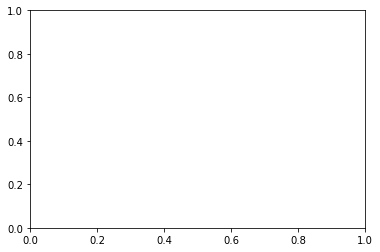

In [69]:
# Define mining regions with score of 1, non-mining=0
status = np.zeros(npts,dtype=int)
status[idx] = 1
# plot the mining/non-mining areas
fig=plt.figure()
plt.scatter(lon_min,lat_min,c=status)
#plt.scatter(lon_min[calc_stat==1],lat_min[calc_stat==1],c=calc_stat[calc_stat==1])
plt.show()


In [19]:
# we probably have too many non-mining pixels. 
# Here we will reduce the size of the non-mining data set
#Because few points are attributed to mining regions, we need to reduce the number of non-mining data points
# make the split approximately 20-80%. ie 80% of data are non-mining, 20% are mining.
# Alternaively, one can be smart about the creation on the initial .csv file we read at the start and ensure it just contains good training data and 
# a good split. In which case we can remove this section. 
count=0
idt=[]
idf=[]
for i in range(len(status)):
    if(status[i] == 1):
        count+=1
        idt.append(i)
    else:
        idf.append(i)

idt=np.array(idt,dtype=int)
idf=np.array(idf,dtype=int)
ratio = count/len(status) 

# we want np.sum(status)/len(status) = 0.2 ie 20% mining pixels
# we cannot increase mine pixels, but we can reduce the number of non-mining pixels 
# want len(status) = np.sum(status) / 0.2
frac = 0.6

idf = idf[0:int(np.sum(status) / frac)]


# Final array is the appending of the idf and idt indices
idx = np.hstack((idt,idf))

# reduce data set if the above is ran
lon_min = lon_min.values[idx]
lat_min =lat_min.values[idx]
lon_max = lon_max.values[idx]
lat_max = lat_max.values[idx]
mine_veg_loss = mine_veg_loss.values[idx]
bare_initial = bare_initial.values[idx]
sar = sar.values[idx]
nirg = nirg.values[idx]
swir1 = swir1.values[idx]
nasa_elev = nasa_elev.values[idx]
gedi_loss = gedi_loss.values[idx]
gedi_qual = gedi_qual.values[idx]
b5 = b5.values[idx]
b6 = b6.values[idx]
elev_score = elev_score.values[idx]
band_ratio = band_ratio.values[idx]
ndmi = ndmi.values[idx]
status = status[idx]
calc_stat = calc_stat[idx]


In [65]:
# put all the data into one array
data = np.array([lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat,status])

(19, 28877)


In [89]:
def routine(data_raw,thresh):
    #                    0         1     2       3         4            5         6   7     8       9         10        11    12 13     14        15      16    18         19
    #data = np.array([lon_min,lat_min,lon_max,lat_max,mine_veg_loss,bare_initial,sar,nirg,swir1,nasa_elev,gedi_loss,gedi_qual,b5,b6,elev_score,band_ratio,ndmi,calc_stat,status])
    # thresh has shape [nparam,1]
    #"""
    # veg loss and bare earth
    id1 = np.logical_and(data_raw[4,:] < thresh[0] , data_raw[5,:] > thresh[1])
    # sar and nirg
    id2 = np.logical_and(data_raw[6,:] > thresh[2] , data_raw[7,:] <= thresh[3])
    # swir1 and elev
    id3 = np.logical_and(data_raw[8,:] < thresh[4] , data_raw[14,:] >= thresh[5])
    # just band score
    id4 = np.logical_and(data_raw[15,:] >= thresh[6] , data_raw[15,:] >= thresh[6])

    # pool these together
    id5 = np.logical_and(id1==True,id2==True)
    id6 = np.logical_and(id3==True,id4==True)
    
    idf = np.logical_and(id5==True,id6==True)


    # veg loss and sar
    id1p = np.logical_and(data_raw[4,:] >= thresh[0] , data_raw[6,:] > thresh[2])
    # nirg and swir1
    id2p = np.logical_and(data_raw[7,:] <= thresh[3] , data_raw[8,:] < thresh[4])

    idfp = np.logical_and(id1p==True,id2p==True)

    # Final is either idf == True OR idfp ==True

    stat = np.logical_or(idf==True, idfp == True)
    """
    # Below is a loop of the above, same thing
    stat = np.zeros(data_raw.shape[1],dtype=int)
    for i in range(data_raw.shape[1]):
        if(data_raw[4,i] < thresh[0] and data_raw[5,i] > thresh[1]):
             if( data_raw[6,i] > thresh[2] and data_raw[7,i] <= thresh[3] and data_raw[8,i] < thresh[4] , data_raw[14,i] >= thresh[5] and data_raw[15,i] >= thresh[6]):
                stat[i] = 1
        elif(data_raw[4,i] >= thresh[0] and data_raw[6,i] > thresh[2] and data_raw[7,i] <= thresh[3] and data_raw[8,i] < thresh[4]):
            stat[i] = 1
    """

    return(stat)

In [148]:
fit_kws={'xtol':1e-35,'ftol':1e-35}
def regression(params,shape,data_array):
    d0 = params[0]
    d1 = params[1]
    d2 = params[2]
    d3 = params[3]
    d4 = params[4]
    d5 = params[5]
    d6 = params[6]

    thresh = [d0,d1,d2,d3,d4,d5,d6]

    data_array = np.reshape(data_array,(shape[0],shape[1]))

    true_status = data_array[-1,:]

    # calculate new scores/metrics
    calc_status = routine(data_array,thresh)

    # Now we need to determine a scoring metric using true_status(within polygon) and calc_status(calculated with new thresholds)
    # Ideally, in the end, we want true_status - new_status = 0 
    # because mine_pixel_status == 1, non_min = 0

    # this is a vector of all pixels correctly classified as mine or non-mine: idx == 0 ==True/Correct, idx == 1 ==False/Wrong, as we are subtracting the True/False indicators
    idx = abs(true_status - calc_status)

    residual = idx

    # Print the #bad pixels during optimization
    mn = np.nansum(residual)
    print("Total Bad Points = ",mn)

    return(mn)


In [177]:
# Now we have our training data set which we will fit.
# define our variables
# We have options: sar, nirg, swir1, mine_veg_loss, bare_initial, ndmi, elev_score, band_ratio, b5, b6
# For now let us do 6 variables: veg loss, bare, sar,nirg,swir1,elev_score and band_ratio

In [ ]:
#Here we test our code to make sure routine is working correctly
# Below are the initial variables/thresholds in GEE_Module
params = np.array([20,20,25,0.3,0.65,5,4])
d0 = params[0]
d1 = params[1]
d2 = params[2]
d3 = params[3]
d4 = params[4]
d5 = params[5]
d6 = params[6]


thresh = [d0,d1,d2,d3,d4,d5,d6]

data_array = np.reshape(data.flatten(),(data.shape[0],data.shape[1]))

# True status are the pixels within the polygon
true_status = data_array[-1,:]
calc_status = routine(data_array[:,:],thresh)

score = np.sum(abs(true_status - calc_status))
print("Bad Points = ",score)

mine_calc_status = np.where(calc_status==1)[0]
non_mine_calc_status = np.where(calc_status==0)[0]


fig=plt.figure()
plt.scatter(data_array[0,mine_calc_status],data_array[1,mine_calc_status],c='black',label='optim_mine',s=0.1)
plt.scatter(data_array[0,non_mine_calc_status],data_array[1,non_mine_calc_status],c='blue',label='optim_non_mine',alpha=0.9,s=0.1)
# below we plot the GEE_Module results for mines if desired
#plt.scatter(data_array[0,np.where(data_array[-2,:]==1)[0]],data_array[1,np.where(data_array[-2,:]==1)[0]],c='red',s=0.1,label='Initial/Old Results')
plt.legend()
plt.show()



In [151]:
# Set ranges/bounds on our variables below
bnds = ((1,100),(1,100),(1,100),(0,1),(0,1),(1,8),(1,8))
# x0 is our first guess parameters
# below it is ordered: veg,bare,sar,nirg,swir1,elev,band_score
t_opt = minimize(regression, x0=np.array([20,20,25,0.3,0.65,5,4]),args=(data.shape,data.flatten()),method='Powell',tol=1e-20,options={'maxiter':2000},bounds=bnds)
print(t_opt)


7082.0
7101.0
7134.0
7100.0
7102.0
7082.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7042.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7036.0
7274.0
7692.0
7032.0
6896.0
6771.0
6708.0
6666.0
6614.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6584.0
6233.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0
6163.0

[ 6.51708126 91.0731774   1.80493182  0.618034    0.6925902   2.0212863
  2.02128627]
6113.0


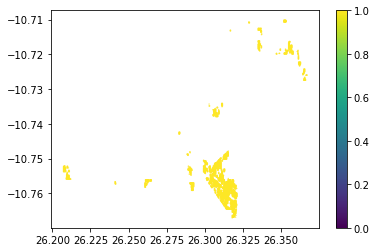

In [167]:
#Evaluate scores from the optimization
# new params
params = t_opt.x
d0 = params[0]
d1 = params[1]
d2 = params[2]
d3 = params[3]
d4 = params[4]
d5 = params[5]
d6 = params[6]


thresh = [d0,d1,d2,d3,d4,d5,d6]

data_array = np.reshape(data.flatten(),(data.shape[0],data.shape[1]))

true_status = data_array[-1,:]
calc_status = routine(data_array[:,:],thresh)

score = np.sum(abs(true_status - calc_status))
print("Bad Points = ",score)

mine_calc_status = np.where(calc_status==1)[0]
non_mine_calc_status = np.where(calc_status==0)[0]


fig=plt.figure()
plt.scatter(data_array[0,mine_calc_status],data_array[1,mine_calc_status],c='black',label='optim_mine',s=0.1)
plt.scatter(data_array[0,non_mine_calc_status],data_array[1,non_mine_calc_status],c='blue',label='optim_non_mine',alpha=0.9,s=0.1)
# below we plot the GEE_Module results for mines if desired
#plt.scatter(data_array[0,np.where(data_array[-2,:]==1)[0]],data_array[1,np.where(data_array[-2,:]==1)[0]],c='red',s=0.1,label='Initial/Old Results')
plt.legend()
plt.show()

